Where we attempt to replicate the mixture data example from Figure 1

In [1]:
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

from einops import repeat

from engression_pytorch import energy_score, gConcat

torch.Size([60000, 2])

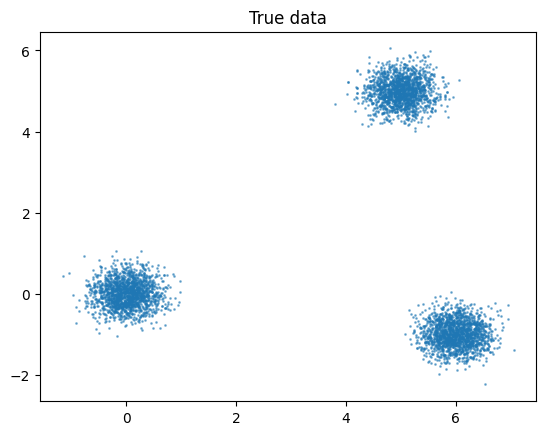

In [2]:
# Generate data

# Mixture of three 2d Gaussian distributions
n = 20_000
X = []
for mean in [(0, 0), (5, 5), (6, -1)]: # p = 1/3
    X.append(np.random.multivariate_normal(mean, np.eye(2) * 0.1, n))

X = np.vstack(X)
np.random.shuffle(X)
X = torch.from_numpy(X).float()

plt.plot(X[:5000,0], X[:5000,1], 'o', markersize = 1, color = 'tab:blue', alpha = 0.5)
plt.title('True data')
X.shape

In [3]:
# A simple 
T = 10

# Example 1: diffusion process
sigmas = torch.linspace(1e-3, 1, T)             # 1 at T -- also called beta ("beta scheduling")
alpha_bar = torch.cumprod(1 - sigmas, dim = 0)  # 0 at T
diff_Xt = lambda x, t, noise: alpha_bar[t].sqrt() * x + (1 - alpha_bar[t]).sqrt() * noise


# Example 3: flow process
flow_Xt = lambda x, t, noise: (1 - t/T) * x + (t/T) * noise 

sample_Xt = flow_Xt # which one to use

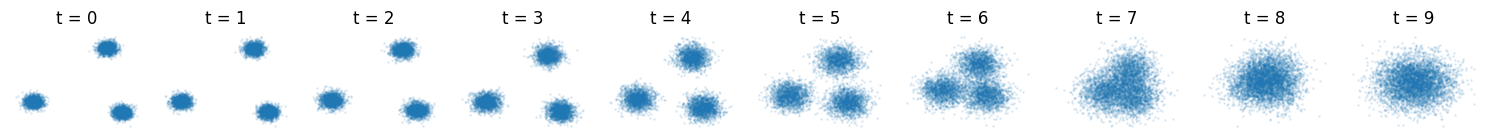

In [4]:
# Display forward corruption process

cols = min(10, T)
rows = (T + cols - 1) // cols  # enough rows to display all Ts
f, axs = plt.subplots(rows, cols, figsize = (1.5 * cols, 1.5 * rows))

for i, ax in enumerate(axs.flatten()):

    if i >= T:
        ax.axis('off')
        continue

    x = X[:5000]
    noise = torch.randn_like(x)
    X_t = sample_Xt(x, i, noise)

    ax.plot(X_t[:, 0], X_t[:, 1], 'o', markersize = 1, color = 'tab:blue', alpha = 0.1)
    ax.set_title(f't = {i}')
    ax.axis('off')

plt.tight_layout()

In [5]:
input_dim, hidden_dim, output_dim = 2, 256, 2
noise_dim = 64 - input_dim - 1


# Try first with a simple MLP + residual
# very crude -- time is not even embedded
class M(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim + noise_dim + 1, hidden_dim),
            nn.ReLU(),
            *[
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU()
            ] * 3,
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        # add a residual just for data
        return self.model(x) + x[:, :input_dim] # x[data, t, noise]
    
model = M()

# And concat the engression noise (eps) during the forward pass
g = gConcat(model, m_train = 2, m_eval = 1, noise_dim = noise_dim)

opt = torch.optim.Adam(model.parameters(), lr = 3e-4)
ds = torch.utils.data.TensorDataset(X)
dl = torch.utils.data.DataLoader(ds, batch_size = 512, shuffle = True)

In [6]:
# Training loop

losses = defaultdict(list)
first_comps = defaultdict(list)
second_comps = defaultdict(list)

g.train()

for _ in range(100):

    for x, in dl:
        
        # Sample t (a single one for the whole batch)
        t = torch.randint(1, T, (1,))
        t = repeat(t, '1 -> b 1', b = x.shape[0])

        # Sample (x_{t-1}, x_t)
        noise = torch.randn_like(x)
        x_tm1, x_t = sample_Xt(x, t - 1, noise), sample_Xt(x, t, noise)

        opt.zero_grad()

        # Forward: predict x_{t-1} from x_t
        inp = torch.concat((x_t, t), dim = 1)
        preds = g(inp)
        loss, _1st_cmp, _2nd_cmp = energy_score(y = x_tm1, preds = preds, return_components = True)

        loss.backward()
        opt.step()

        losses[t[0].item()].append(loss.item())
        first_comps[t[0].item()].append(_1st_cmp.item())
        second_comps[t[0].item()].append(_2nd_cmp.item())

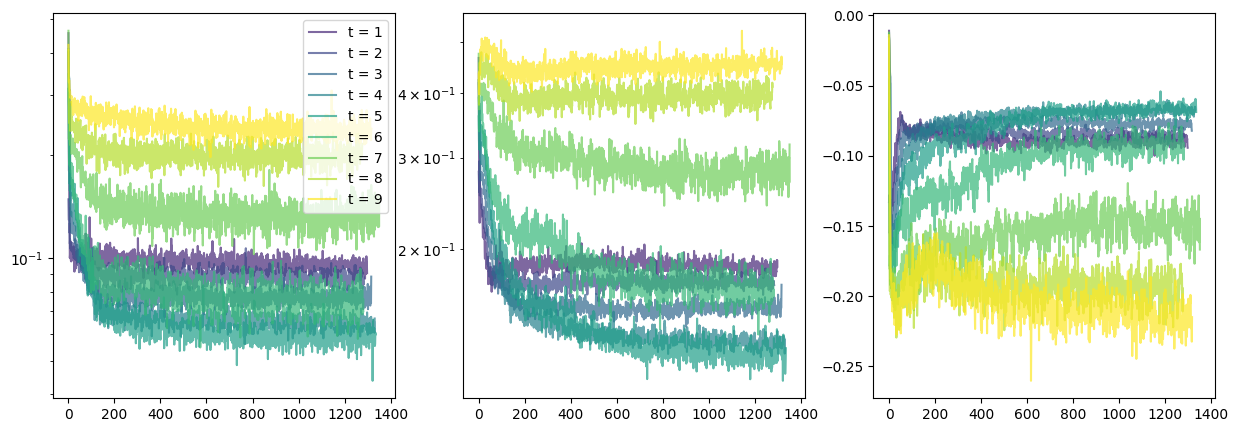

In [10]:
# Take a look at the losses
cmap = plt.get_cmap('viridis')
# for t in range(1, T):
#     plt.plot(losses)

f, axs = plt.subplots(1, 3, figsize = (15, 5))
for t in range(1, T):
    color = cmap(t / (T - 1)) 
    for ax, l in zip(axs, [losses, first_comps, second_comps]):
        ax.plot(l[t], label = f't = {t}', alpha = 0.7, color = color)


axs[0].legend()
axs[0].set_yscale('log')
axs[1].set_yscale('log')

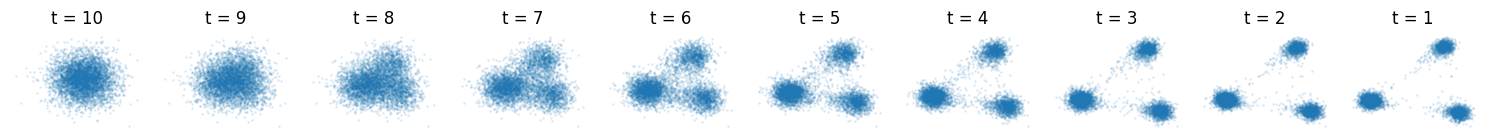

In [22]:
# Sample from the model

g.eval() # sets m in gConcat to 1

with torch.no_grad():

    x = torch.randn_like(X[:5000])
    xs = {T:x.clone()}

    for t in reversed(range(1, T)):
        
        t = torch.tensor([t])
        t = repeat(t, '1 -> b 1', b = x.shape[0])
        inp = torch.concat((x, t), dim = 1)
        x = g(inp)[:, 0, :]

        xs[t[0].item()] = x.clone()



# Plot chain
cols = min(11, len(xs.keys()))
rows = (T + cols - 1) // cols
f, axs = plt.subplots(rows, cols, figsize = (1.5 * cols, 1.5 * rows))

for (t, x), ax in zip(xs.items(), axs.flatten()):
    ax.plot(x[:, 0], x[:, 1], 'o', markersize = 1, color = 'tab:blue', alpha = 0.1)
    ax.set_title(f't = {t}')
    ax.axis('off')

f.tight_layout()

Not as good as the figure, but good (and simple) enough.